# Reasoning & Planning
### 학습 목표
1. Chain-of-Thought가 무엇인지 알아보고, 성능을 확인해 본다.
2. Zero-shot CoT가 무엇인지 알아보고, 기존 CoT와의 차이를 확인해 본다.
3. Least-to-Most Prompt를 코드로 확인하고 성능을 확인해 본다.
4. Decomposed Prompt를 활용하고 Planning의 가능성을 확인한다.

***context***
1. Naive Prompt
2. Chain-of-Thought Prompting (COT)
3. Zero-shot COT
4. Least-to-Most Prompting
5. Decomposed Prompting

## 0. 준비과정

본 실습에선 Llama2 모델 혹은 OpenAI의 GPT-3.5 (gpt-3.5-turbo-instruct) 모델을 활용할 것이다.
* OpenAI API를 유료 사용 중이거나 무료 사용기간이 끝나지 않았다면 가급적 OpenAI 모델로 실습하는 것을 권장한다. Llama2 모델의 경우 원하는 결과를 도출하지 못할 수도 있다.
* 실습 강의 영상에선 OpenAI API를 사용하며, Llama2로 실습을 한다면 강의의 결과를 참고하자.


### 공통 Library

In [1]:
! pip install tenacity

In [2]:
import re
from typing import List, Any
from tenacity import retry, stop_after_attempt, wait_fixed

### Llama2

In [1]:
! pip install -q "transformers>=4.35.2" "accelerate>=0.24.1" "bitsandbytes>=0.41.2" "sentencepiece>=0.1.99"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import torch
import transformers
from transformers import LlamaTokenizer, StoppingCriteria, StoppingCriteriaList, BitsAndBytesConfig, pipeline

In [3]:
llama_model = "NousResearch/Llama-2-13b-chat-hf"

llama_tokenizer = LlamaTokenizer.from_pretrained(llama_model)
llama = pipeline( # transformer의 pipeline은 모델 생성을 지원한다.
    "text-generation",
    model=llama_model, # 모델을 입력한다
    tokenizer=llama_tokenizer, # 토크나이저를 입력한다
    torch_dtype=torch.float16,
    model_kwargs={
        "quantization_config": BitsAndBytesConfig(
            load_in_4bit=True, # bitsandbytes를 통해 4bit로 Quantization하여 모델을 불러온다.
            bnb_4bit_compute_dtype=torch.bfloat16
        )
    }
)

# 모델의 생성을 멈출 문자를 지정하기 위한 클래스이다.
class StopWordCriteria(StoppingCriteria):
    def __init__(self, stop: str, tokenizer: LlamaTokenizer) -> None:
        StoppingCriteria.__init__(self)
        self.stop = stop
        self.tokenizer = tokenizer

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> bool: # 토큰을 하나 생성할 때마다 실행되며, Boolean을 반환한다. True를 반환한다면 생성을 중단한다.
        return any(
            decoded.endswith(self.stop)
            for decoded in self.tokenizer.batch_decode(input_ids)
        )

# llama의 생성을 위한 함수이다.
def complete_llama(prompt: str, stop: str=None) -> str:
    sequences = llama(
        prompt,
        do_sample=True,
        stopping_criteria=StoppingCriteriaList([StopWordCriteria(stop, llama_tokenizer)]) if stop is not None else None, # 위에서 정의한 클래스를 사용한다.
        max_new_tokens=128,
        temperature=0.7,
    )[0]['generated_text']

    sequences = sequences[len(prompt):]
    if stop is not None and sequences.endswith(stop):
        sequences = sequences[:-len(stop)]

    return sequences


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

### OpenAI GPT-3.5

In [ ]:
! pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key="여기에 OPENAI_API_KEY를 입력하세요."
)

# wait_fixed(3) : 각 시도마다 3초를 기다린다.
# stop_after_attempt(5) : 최대 5번까지만 시도한다.
@retry(wait=wait_fixed(3), stop=stop_after_attempt(5))
def complete_openai(prompt: str, stop: str=None) -> str:
    return client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        max_tokens=1024,
        temperature=0.8,
        stop=stop
    ).choices[0].text

### 실행 코드 선택
아래 코드에서 Llama 2와 GPT-3.5중 어떤 모델을 사용할지 선택한다. 가급적 GPT-3.5를 사용할 것을 권하며, 실습 강의에선 GPT-3.5를 사용한다.

* Llama2 : complete_llama
* GPT-3.5 : complete_openai

In [ ]:
# model 선택
complete = complete_openai   # Option: [complete_llama, complete_openai]

print(complete("The most famous food of Korea is", stop="."))

 Kimchi


In [ ]:
# 생성된 문장에서 답을 뽑아내는 코드이다.
# 언어 모델의 Output을 완전히 제어하는 것은 어렵기에, 이처럼 모델의 응답을 후처리하는 일은 종종 동반된다.
def extract_answer(text) -> str:
    number = re.findall('[\d,]+', text) # 숫자를 뽑아낸다.
    if number:
      answer = int(number[-1].replace(',', ''))
    else:
        answer = None
    return answer

### GSM8K 데이터셋 알아보기

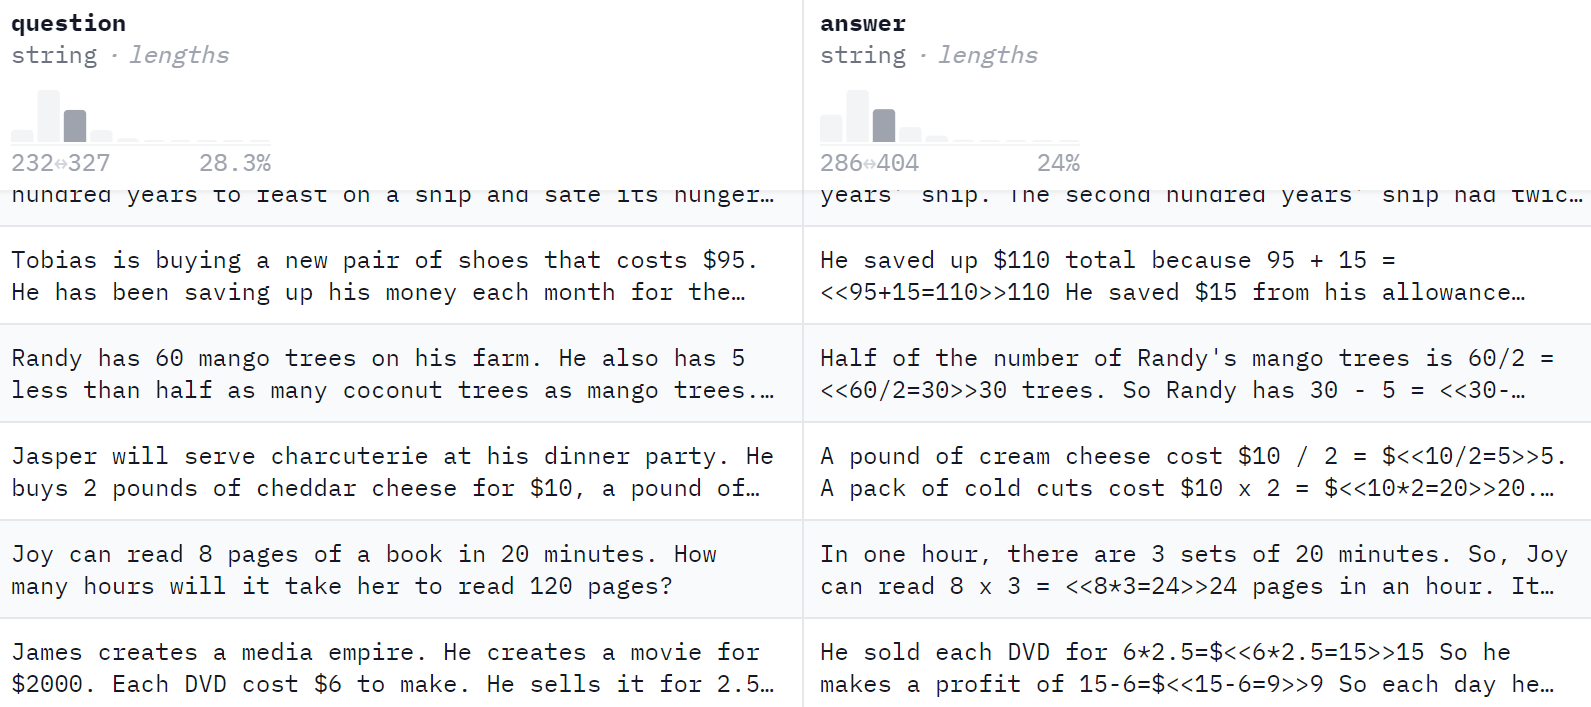

> GSM8K

GSM8K 데이터셋은 초등학교 수학 문제를 모아둔 데이터셋이다. 언어 모델은 Chain of Thought와 같은 사고 과정 기반의 프롬프팅을 사용하기 이전, 이러한 숫자 연산에 취약한 모습을 보였다.

본 실습에서 다룰 다양한 Prompting 기법들은 해당 데이터셋에서 비교적 우수한 성능을 보인다.

* 이하의 실습은 항상 같은 답변을 도출하지 않으므로, 원하는 답이 나오지 않을 수 있다. 그렇기 때문에 코드를 여러 번 실행하며 정답이 나오는 횟수를 참고하길 바란다.

* OpenAI API를 사용하는 경우에 비해 Llama 2가 안 좋은 답변을 출력할 수 있다. 이는 프롬프팅 방식이 모델 성능에 의존하기 때문이며, 더 쉬운 질문으로 교체하여 결과를 확인해 보자.

## 1. Naive Prompt
우선 별도의 Reasoning 기법을 적용하지 않고, 우리가 일반적으로 사용하는 프롬프팅을 하였을 때의 결과를 확인해 보자.


In [ ]:
PROMPT = """\
Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A: The answer is 72.
Q: The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day, how many will be left after 3 days?
A: The answer is\
""" ### 정답은 145이다.

output = complete(PROMPT, stop='\n')
print("모델의 생성 결과:", output)
print("추출된 답:", extract_answer(output))

모델의 생성 결과:  174.
추출된 답: 174


## 2. Chain-of-Thought Prompting (CoT)

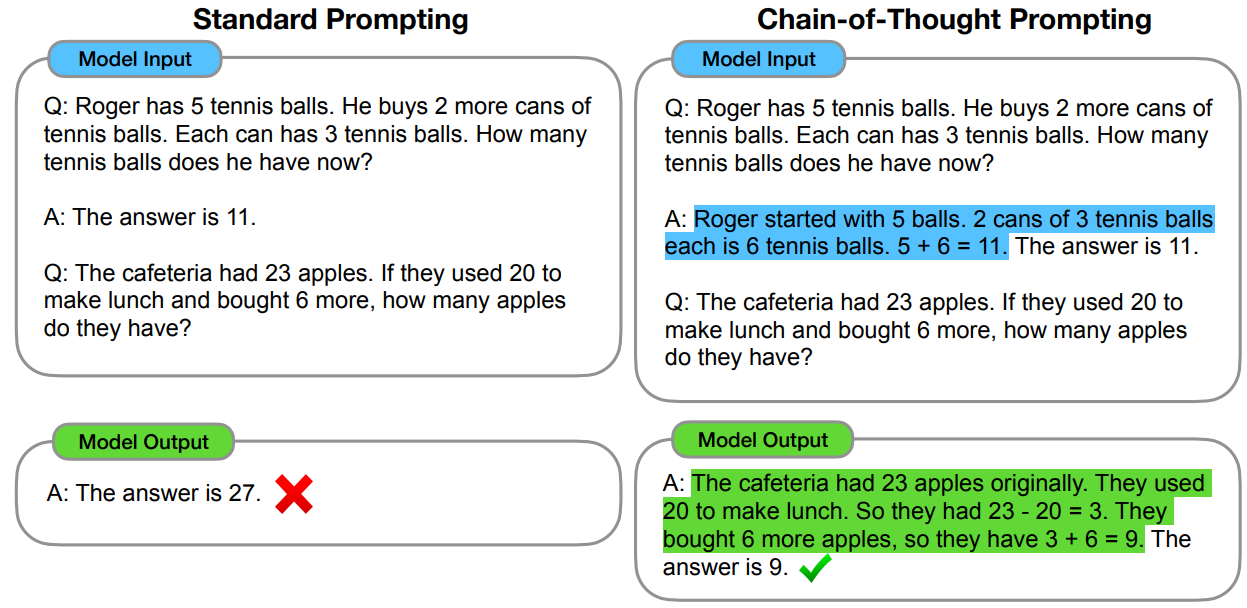

> Chain-of-Thought Prompting

Chain of Thought Prompting (CoT)은 Prompt를 통해 LLM에게 문제를 풀기 위한 일련의 사고의 연쇄 과정을 예시로써 주는 방법론이다. 기존 Prompting의 경우, 모델은 질문에 대해 바로 정답을 출력해야 한다.

CoT는 인간이 수학 문제를 푸는 것처럼, 일종의 사고 과정을 통해 정답을 출력할 수 있도록 한다.

In [ ]:
PROMPT = """\
Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A: Natalia sold 48/2 = 24 clips in May. Natalia sold 48+24 = 72 clips altogether in April and May. The answer is 72.
Q: The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day, how many will be left after 3 days?
A:\
""" ### 정답은 145이다.

### 아래는 더 쉬운 질문이다. 아래 결과 역시 함께 확인해 보자.
# PROMPT2 = """\
# Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
# A: Natalia sold 48/2 = 24 clips in May. Natalia sold 48+24 = 72 clips altogether in April and May. The answer is 72.
# Q: The cafeteria had 325 apples. If they consume 60 each day, how many will be left after 3 days?
# A:\
# """

output = complete(PROMPT, stop='\n')
print("모델의 생성 결과:", output)
print("추출된 답:", extract_answer(output))

모델의 생성 결과:  After 3 days, the cafeteria would have used 23+37 = 60 apples per day. In 3 days, they would have used a total of 60*3 = 180 apples. Therefore, there would be 325-180 = 145 apples left after 3 days. The answer is 145.
추출된 답: 145


이처럼 Naive한 Prompt보다 사고 과정을 활용한 CoT Prompt가 더 좋은 결과를 보여준다.

이러한 기법을 수학 문제가 아닌 일상적인 질문에 어떻게 적용할 수 있을지도 함께 고민해 보자.


## 3. Zero-shot Chain-of-Thought

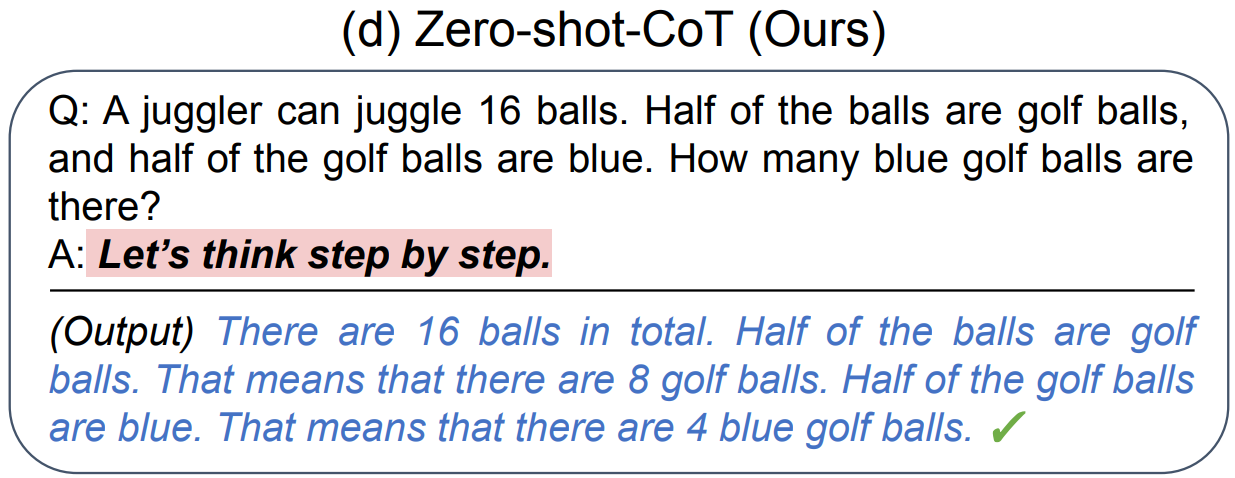

> Zero-shot CoT

CoT의 경우, output에 간단한 정답뿐만 아니라, 그에 대한 추론 과정도 포함되어야 한다. 이를 위해선 In-context example에도 추론 과정을 함께 입력해 줘야 하며, 이는 인간의 노동력을 필요로 하는 일이다.

이 문제점을 해결하기 위해, Zero-shot COT는 먼저 별도의 예시 없이 **Let's think step by step**이라는 Prompt를 통해 모델의 사고하는 과정을 끌어낸다. 이후 생성된 사고 과정을 기반으로 최종 답을 도출한다.

In [ ]:
PROMPT = """\
Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A: Let's think step by step.""" ### 정답은 72이다.

reasoning_step = complete(PROMPT, stop='Q:')
print("생성된 사고 과정:", reasoning_step)

answer_extracts = reasoning_step + '\nTherefore, the answer is' # Therefore, the answer is 를 연결함으로써, 답변을 추출한다.
output = complete(answer_extracts, stop='\n')
print("생성된 답변:", output)
print("추출된 답:", extract_answer(output))

생성된 사고 과정:  
First, Natalia sold 48 clips in April.
Then, she sold half as many clips in May. 
Half of 48 is 48 ÷ 2 = 24. 
Therefore, Natalia sold 24 clips in May. 
To find the total number of clips sold in April and May, we need to add the number of clips sold in each month. 
So, the total number of clips sold is 48 + 24 = 72. 
Therefore, Natalia sold 72 clips altogether in April and May.
생성된 답변:  72.
추출된 답: 72


## 4. Least-to-Most Prompting



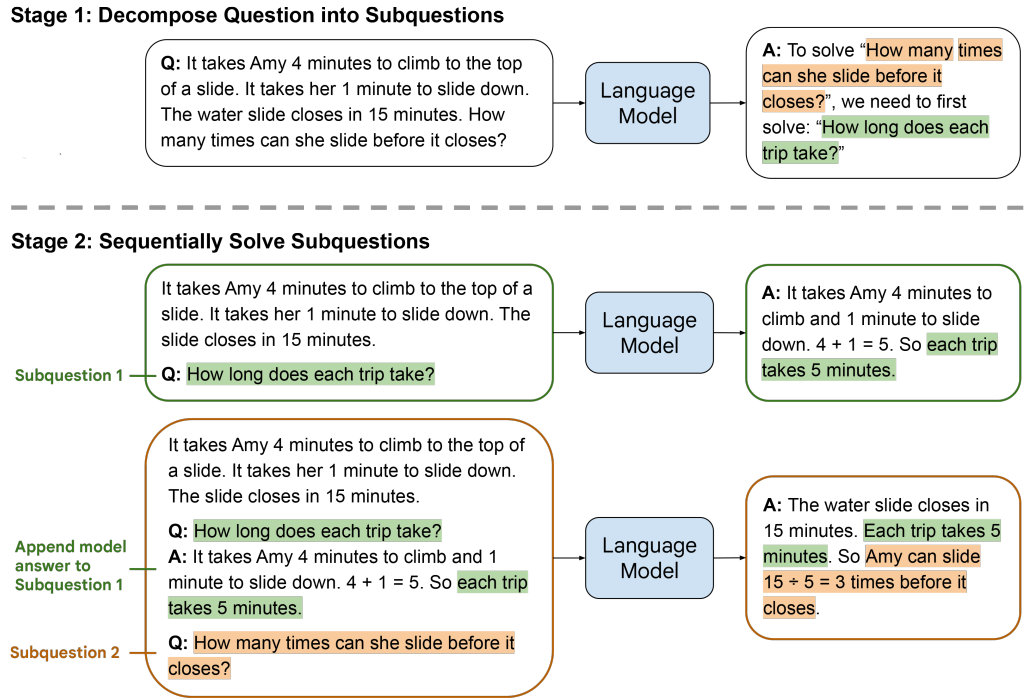

> Least-to-Most Prompting

Least-to-Most Prompting은 문제를 여러 작은 질문들로 분할한 이후에 각 작은 질문들을 해결하며 최종 답을 도출하는 기법이다.

In [ ]:
context = "It takes Amy 4 minutes to climb to the top of a slide. It takes her 1 minute to slide down. The water slide closes in 15 minutes."
main_question = " How many times can she slide before it closes?"

### Decomposing Prompt
질문을 비교적 쉬운 여러 개의 문제들로 나눠주는 프롬프트를 정의한다.

In [ ]:
import re

DECOMPOSING_PROMPT = """\
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May.
Q: How many clips did Natalia sell altogether in April and May?
A: To answer the question "How many clips did Natalia sell altogether in April and May?", we need to know: "How many clips did Natalia sell in April?", "How many clips did Natalia sell in May?".

The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day.
Q: How many will be left after 3 days?
A: To answer the question "How many will be left after 3 days?", we need to know: "How many apples were available at the beginning?", "How many apples did they consume each day?".

James writes a 3-page letter to 2 different friends twice a week.
Q: How many pages does he write a year?
A: To answer the question "How many pages does he write a year?", we need to know: "How many letters does James write per week?", "How many pages does each letter have?".

{context}
Q: {question}
A: To answer the question "{question}", we need to know:"""

output = complete(DECOMPOSING_PROMPT.format(context=context, question=main_question), stop='\n\n')
sub_questions = [
    sub_question for sub_question in re.findall(r'(?<=")[^"]+(?=")', output)
    if sub_question != ', '
]

print("풀어야할 작은 문제들")
for i, sub_question in enumerate(sub_questions, start=1):
    print(f"문제 {i}:", sub_question)



풀어야할 작은 문제들
문제 1: How long does it take Amy to climb to the top of the slide?
문제 2: How long does it take Amy to slide down?
문제 3: How long is the water slide open for?


### Solving Prompt
Decomposing Prompt를 통해 우리가 풀어야할 문제를 여러 개의 작은 문제들로 나누어주었다. 이제 작은 문제들을 풀어준 다음 최종적으로 우리가 원하는 문제를 풀어보자.

In [ ]:
SOLVING_PROMPT = """\
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May.
Q: How many clips did Natalia sell in April?
A: "Natalia sold clips to 48 of her friends in April". So the answer is 48.
Q: How many clips did Natalia sell in May?
A: Because Natalia sold half as many clips in May, she sells 48/2=24. So the answer is 24.
Q: How many clips did Natalia sell altogether in April and May?
A: Natalia sold a total of 48 + 24 = 72 clips in April and May.

The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day.
Q: How many apples were available at the beginning?
A: "The cafeteria had 325 appels.". So the answer is 325.
Q: How many apples did they consume each day?
A: Because they consume 23 for lunch and 37 for dinner each day, 23+37=60. So the answer is 60.
Q: How many will be left after 3 days?
A: 325 - 60 - 60 - 60 = 145 apples.

James writes a 3-page letter to 2 different friends twice a week.
Q: How many letters does James write per week?
A: James writes 4 letter per week. So the answer is 4.
Q: How many pages does each letter have?
A: "James writes a 3-page letter". So the answer is 3.
Q: How many pages does he write a year?
A: He writes 12*52=624 pages a year.

{context}"""
sub_questions.append(main_question)

prompt = SOLVING_PROMPT.format(context=context)
for i, question in enumerate(sub_questions, start=1):
    prompt += '\nQ: {question}\nA:'.format(question=question)
    output = complete(prompt, stop='\n')
    prompt += output
    print(f"생성 문장 {i}:", output)

print("추출된 답:", extract_answer(output)) # 답은 3

print(prompt)

생성 문장 1:  "It takes Amy 4 minutes to climb to the top of a slide". So the answer is 4 minutes.
생성 문장 2:  According to the given information, it takes Amy 1 minute to slide down. So the answer is 1 minute.
생성 문장 3:  The water slide is open for 15 minutes according to the given information. So the answer is 15 minutes. 
생성 문장 4:  In 15 minutes, Amy can slide 15/5=3 times. So the answer is 3 times.
추출된 답: 3
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May.
Q: How many clips did Natalia sell in April?
A: "Natalia sold clips to 48 of her friends in April". So the answer is 48.
Q: How many clips did Natalia sell in May?
A: Because Natalia sold half as many clips in May, she sells 48/2=24. So the answer is 24.
Q: How many clips did Natalia sell altogether in April and May?
A: Natalia sold a total of 48 + 24 = 72 clips in April and May.

The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day.
Q: How many apples were av

## 5. Decomposed Prompting

> Decomposed Prompting이란?

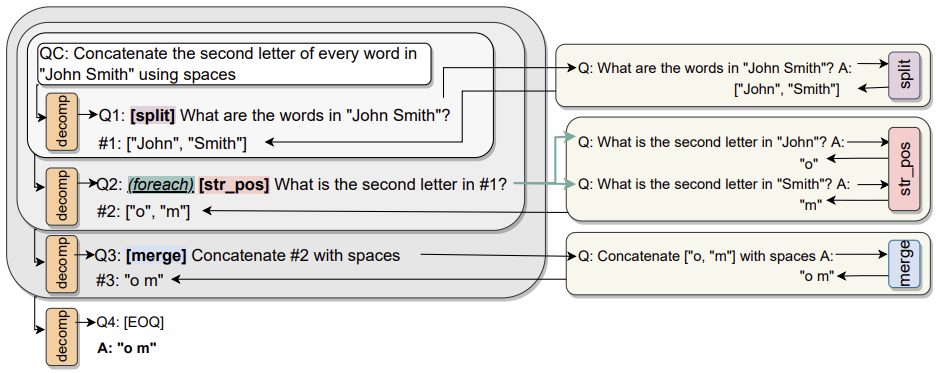

Decomposed Prompting은 해결하고자 하는 task가 있을 때, 사전에 작은 task를 미리 정의한다. 이후 주어진 Input을 사전에 정의한 작은 task로 나누는 Decomposer와 각 task를 풀기 위한 Sub-task Handler를 사용한다.

그림은 "John Smith"에서 모든 단어의 두 번째 문자를 공백으로 이어 붙이는 task이다. Decomposer에 의해 주어진 문제를 [split], [str_pos], [merge]라는 3가지의 Task로 나눈 이후, 각각의 Sub-task Handler의 결과를 통해 문제를 해결한다.

아래와 같이 각 단어 내 특정 위치에 있는 문자들을 조합하는 문제를 생각해 보자.

* Least-to-Most Prompting과 굉장히 유사한 프롬프팅 방식이며, 명확히 차이를 구분할 것을 추천한다.

In [ ]:
NAIVE_PROMPT = """\
Q: Take the last letters of the words in "Clinton Yanira Barbara Betsy" and concatenate them using a space.
A: "n a a y"

Q: Take the letters at position 2 of the words in "Violeta Clay Janelle Mac" and concatenate them.
A: "i l a a"

Q: Take the letters at position 3 of the words in "Bernard Lidia Sebastian Judy" and concatenate them using a space.
A: "r d b d"

QC: {question}
A:\
"""

def naive_solution(question: str) -> str:
    return complete(
        NAIVE_PROMPT.format(question=question),
        stop='\n'
    ).lstrip()

In [ ]:
print(naive_solution('Concatenate the second letter of every word in "Gavin Neha Asha Baltazar" using spaces.')) # 정답은 a e s a

"a e s l"


위 예시처럼 기본적인 Few-shot learning의 방법만으로는 해당 과제를 적절히 수행하지 못한다는 것을 확인할 수 있다.

이러한 과제는 인간은 굉장히 쉽게 해결할 수 있으나, Sub-word token으로 텍스트를 해석하고 결과를 생성하는 언어 모델에겐 어려운 과제이다.

본 과제를 효과적으로 풀기 위하여, 몇 가지 함수들을 사전에 정의하고 해당 함수들을 호출하여 문제를 풀 수 있는 Prompt를 작성해 보자.

* split
* merge
* arr_position
* str_position

### split

split 프롬프트는 주어진 문자열을 나눈다.

In [ ]:
SPLIT_PROMPT = """\
Q: What are the words in "Clinton Yanira Barbara Betsy"?
A: ["Clinton", "Yanira", "Barbara", "Betsy"]

Q: What are the letters in "Clinton"?
A: ["C", "l", "i", "n", "t", "o", "n"]

Q: What are the letters and their positions in "Betsy"?
A: [("B", 1), ("e", 2), ("t", 3), ("s", 4), ("y", 5)]

Q: What are the words and their positions in "Violeta Clay Janelle Mac"?
A: [("Violeta", 1), ("Clay", 2), ("Janelle", 3), ("Mac", 4)]

Q: {question}
A:\
"""

def split(question: str) -> str:
    return complete(
        SPLIT_PROMPT.format(question=question),
        stop='\n'
    ).lstrip()

In [ ]:
print(split('What are the words in "Gavin Neha Asha Baltazar"?'))

["Gavin", "Neha", "Asha", "Baltazar"]


### merge

merge 프롬프트는 문자 또는 문자열로 이루어진 입력 리스트를 합친다.

In [ ]:
MERGE_PROMPT = """\
Q: Concatenate ["Y", "a", "n", "i", "r", "a"].
A: "Yanira"

Q: Concatenate ["B", "a", "r", "b", "a", "r", "a"] using a space.
A: "B a r b a r a"

Q: Concatenate ["a", "a", "g"] using a comma.
A: "a,a,g"

Q: Concatenate ["Violeta", "Clay", "Janelle", "Mac"] using a space.
A: "Violeta Clay Janelle Mac"

Q: Concatenate ["Allen", "Institute"].
A: "AllenInstitute"

Q: {question}
A:\
"""

def merge(question: str) -> str:
    return complete(
        MERGE_PROMPT.format(question=question),
        stop='\n'
    ).lstrip()

In [ ]:
print(merge('Concatenate ["A", "M", "T"] using a space'))

"A M T"


### arr_position

arr_position은 위치가 함께 주어진 리스트에서 특정 위치에 있는 문자 또는 문자열을 추출한다.

In [ ]:
ARR_POSITION_PROMPT = """\
Q: What is at position 4 in [("Colorless", 1), ("blue", 2), ("thinkings", 3), ("wake", 4), ("seriously", 5)]?
A: "wake"

Q: What is at position 1 in [("V", 1), ("i", 2), ("o", 3), ("l", 4), ("e", 5), ("t", 6), ("a", 7)]?
A: "V"

Q: What is at the last position in [("J", 1), ("a", 2), ("n", 3), ("e", 4), ("l", 5), ("l", 6), ("e", 7)]?
A: "e"

Q: What is at position 3 in [("Bernard", 1), ("Lidia", 2), ("Sebastian", 3), ("Judy", 4)]?
A: "Sebastian"

Q: What is at last position in [("Allen", 1), ("Institute", 2), ("for", 3), ("Artificial", 4), ("Intelligence", 5)]?
A: "Intelligence"

Q: What is at position 4 in [("S", 1), ("e", 2), ("b", 3), ("a", 4), ("s", 5), ("t", 6), ("i", 7), ("a", 8), ("n", 9)]?
A: "a"

Q: {question}
A:\
"""

def arr_position(question: str) -> str:
    return complete(
        ARR_POSITION_PROMPT.format(question=question),
        stop='\n'
    ).lstrip()

In [ ]:
print(arr_position('What is at position 1 in [("A", 1), ("u", 2), ("g", 3), ("u", 4), ("s", 5), ("t", 6), ("a", 7)]?'))

"A"


### str_position

str_position은 주어진 문자열에서 특정 위치에 있는 문자 또는 문자열을 추출한다.

str_position과 arr_position의 차이는, arr_position의 경우 "위치가 함께 주어진 리스트"를 입력으로 받는다는 것인 반면 str_position은 문자열을 입력으로 받는다는 것이다.

따라서 우리는 split과 arr_position을 함께 사용하여 str_position을 정의할 수 있다. 사전에 정의한 함수를 적절한 위치에 사용하여 새로운 함수를 정의해보자.

QC는 어려운 문제(Complex question)를 의미하고, QS는 분리된 더욱 쉬운 문제(Small question)를 칭한다.

먼저, 아래의 Prompt에서 Complex question을 Small question으로 분리할 것이다.

각각의 Small question은 앞서 정의한 프롬프트로 각각 해결하며, 단계별로 생성된 답변을 기반으로 최종 답변을 생성한다.

In [ ]:
STR_POSITION_PROMPT = """\
QC: What is the letter at position 1 of the word "Bernard"?
QS: [split] What are the letters and their positions in "Bernard"?
A: [("B", 1), ("e", 2), ("r", 3), ("n", 4), ("a", 5), ("r", 6), ("d", 7)]
QS: [arr_position] What is at position 1 in #1?
A: "B"
QS: [EOQ]

QC: What is the last letter of the word "Sebastian"?
QS: [split] What are the letters and their positions in "Sebastian"?
A: [("S", 1), ("e", 2), ("b", 3), ("a", 4), ("s", 5), ("t", 6), ("i", 7), ("n", 8)]
QS: [arr_position] What is the last letter in #1?
A: "n"
QS: [EOQ]

QC: What is the word at the position 4 in "Colorless blue thinkings wake seriously"?
QS: [split] What are the words and their positions in "Colorless blue thinkings wake seriously"?
A: [("Colorless", 1), ("blue", 2), ("thinkings", 3), ("wake", 4), ("seriously", 5)]
QS: [arr_position] What is at the position 4 in #1?
A: "wake"
QS: [EOQ]

QC: {question}\
"""

import re
import time
get_function = re.compile(r"(?<=\[)[^\]]+(?=\])") # 대괄호[] 내에 있는 문자열을 추출하는 함수이다. 즉, [split]과 [arr_position]과 같은 사전 정의한 프롬프트를 추출하는 함수이다.
get_question = re.compile(r"(?<=\] ).+$") # ] 뒤에 오는 문자열을 추출한다. 즉, question을 추출한다.
get_slot = re.compile(r"#\d+") # #으로 시작하고 그 뒤에 하나 이상의 숫자가 오는 문자열을 추출한다. 예시로, 문자열 #1 등을 추출한다.

@retry(stop=stop_after_attempt(3))
def str_position(question: str) -> str:
    prompt = STR_POSITION_PROMPT.format(question=question)
    answers = []
    while True:
        prompt += "\nQS:"
        output = complete(prompt, stop='\n') # QS: 뒤에 오는 문자열을 생성한다.
        print("생성된 질문:", output)
        function = get_function.search(output).group(0) # [split]과 [arr_position]과 같은 함수를 추출한다.

        if function == "EOQ":
            return answers[-1] # 함수를 종료한다.

        question = get_question.search(output).group(0) # 함수 뒤에 오는 질문을 추출한다.

        if (m := get_slot.search(question)): # question에서 #1 등의 문자열이 있다면 True
            slot = m.group(0) # 문자열 #1 등을 추출
            question = re.sub(slot, answers[int(slot[1:])-1], question) # int(slot[1:])는 #1에서 1만을 추출하며, -1을 뺌으로써 인덱스로 변환한다.
                                                                        # Ex. question="What is the last letter in #1?", answers[0]="[("K", 1), ("i", 2), ("n", 3), ("g", 4)]"
                                                                        # -> question = "What is the last letter in [("K", 1), ("i", 2), ("n", 3), ("g", 4)]"

        if function == "split":
            answer = split(question)
        elif function == "arr_position":
            answer = arr_position(question)
        else:
            raise NotImplementedError()
        print("출력 답안:", answer)

        prompt += output + "\nA: %s" % answer
        answers.append(answer)


In [ ]:
print("최종 답안:", str_position('What is the last letter in "King"?'))

생성된 질문:  [split] What are the letters and their positions in "King"?
출력 답안: [("K", 1), ("i", 2), ("n", 3), ("g", 4)]
생성된 질문:  [arr_position] What is the last letter in #1?
출력 답안: "g"
생성된 질문:  [EOQ]
최종 답안: "g"


### Main Prompt

이제, 원래 문제를 풀기 위하여 위의 함수들을 모두 사용하는 Prompt를 작성하고, 각 함수가 적절히 호출될 수 있는 코드를 작성해 보자.

언어모델은 주어진 Input에 대해 Demonstration에 주어진 문제 해결 방법을 기반으로 필요한 함수를 호출하며 문제를 해결할 것이다.

In [ ]:
LETTER_CONCATENATE_PROMPT = """\
QC: Take the last letters of the words in "Clinton Yanira Barbara Betsy" and concatenate them using a space.
QS: [split] What are the words in "Clinton Yanira Barbara Betsy"?
A: ["Clinton", "Yanira", "Barbara", "Besty"]
QS: [str_position] What is the last letter in "#1"?
A: ["n", "a", "a", "y"]
QS: [merge] Concatenate #2 using a space.
A: "n a a y"
QS: [EOQ]

QC: Take the letters at position 2 of the words in "Violeta Clay Janelle Mac" and concatenate them.
QS: [split] What are the words in "Violeta Clay Janelle Mac"?
A: ["Violeta", "Clay", "Janelle", "Mac"]
QS: [str_position] What is the letter at position 2 in "#1"?
A: ["i", "l", "a", "a"]
QS: [merge] Concatenate #2 using a space.
A: "i l a a"
QS: [EOQ]

QC: Take the letters at position 1 of the words in "Bernard Lidia Sebastian Judy" and concatenate them using a space.
QS: [split] What are the words in "Bernard Lidia Sebastian Judy"?
A: ["Bernard", "Lidia", "Sebastian", "Judy"]
QS: [str_position] What is the letter at position 1 in "#1"?
A: ["B", "L", "S", "J"]
QS: [merge] Concatenate #2 using a space.
A: "B L S J"
QS: [EOQ]

QC: {question}
A:\
"""

@retry(stop=stop_after_attempt(3))
def letter_concatenate(question: str) -> str:
    prompt = LETTER_CONCATENATE_PROMPT.format(question=question)
    answers = []

    while True:
        prompt += "\nQS:"
        output = complete(prompt, stop='\n')
        print("생성된 질문:", output)
        function = get_function.search(output).group(0) # 대괄호[] 내에 있는 문자열을 추출하는 함수이다. 즉, [split]과 [arr_position]과 같은 사전 정의한 함수를 추출하는 함수이다.

        if function == "EOQ":
            return answers[-1] # 함수를 종료한다.
        question = get_question.search(output).group(0) # ] 뒤에 오는 문자열을 추출한다. 즉, question을 추출한다.

        slot = None
        if (m := get_slot.search(question)): #1 등의 문자열이 있다면 True
            slot = m.group(0) # 문자열 #1 등을 추출

        if function == "split":
            if slot:
                question = re.sub(slot, answers[int(slot[1:])-1], question)
            answer = split(question)

        elif function == "str_position":
            if slot:
                word_list = eval(answers[int(slot[1:])-1]) # Ex. ["Gavin", "Neha", "Asha", "Baltazar"]
                answer = []
                for word in word_list:
                    sub_question = re.sub(slot, word, question) # Ex. What is the first letter in "Gavin"?
                    sub_answer = str_position(sub_question)[1:-1] # Ex. G
                    answer.append(sub_answer)
                answer = str(answer)

        elif function == "merge":
            if slot:
                question = re.sub(slot, answers[int(slot[1:])-1], question) # Ex. Concatenate ["G", "N", "A", "B"]
            answer = merge(question)

        else:
            raise NotImplementedError()

        print("출력 답안:", answer)
        prompt += output + "\nA: %s" % answer
        answers.append(answer)

In [ ]:
print("최종 답안:", letter_concatenate('Concatenate the last letter of every word in "Sally sells seashells by the seashore" using spaces.')) # 답은 y s s y e e

생성된 질문:  [split] What are the words in "Sally sells seashells by the seashore"?
출력 답안: ["Sally", "sells", "seashells", "by", "the", "seashore"]
생성된 질문:  [str_position] What is the last letter in "#1"?
생성된 질문:  [split] What are the letters and their positions in "Sally"?
출력 답안: [("S", 1), ("a", 2), ("l", 3), ("l", 4), ("y", 5)]
생성된 질문:  [arr_position] What is the last letter in #1?
출력 답안: "y"
생성된 질문:  [EOQ]
생성된 질문:  [split] What are the letters and their positions in "sells"?
출력 답안: [("s", 1), ("e", 2), ("l", 3), ("l", 4), ("s", 5)]
생성된 질문:  [arr_position] What is the last letter in #1?
출력 답안: "s"
생성된 질문:  [EOQ]
생성된 질문:  [split] What are the letters and their positions in "seashells"?
출력 답안: [("s", 1), ("e", 2), ("a", 3), ("s", 4), ("h", 5), ("e", 6), ("l", 7), ("l", 8), ("s", 9)]
생성된 질문:  [arr_position] What is the last letter in #1?
출력 답안: "s"
생성된 질문:  [EOQ]
생성된 질문:  [split] What are the letters and their positions in "by"?
출력 답안: [("b", 1), ("y", 2)]
생성된 질문:  [arr_position] What is t

## Planning

> Planning

Planning이란 특정 task를 수행하기 위해 모델이 해결해야 할 작은 문제들을 스스로 정의하고 단계적으로 해결해 나가는 것을 칭한다.

예시로, "1924년 한국에서 일어난 일들을 요약해줘."라고 질문한다면, 모델은 **1. 검색 API를 통해 자료 검색, 2. 자료를 요약**하는 과정을 스스로 정의하고 이를 단계적으로 해결하며 최종 목적을 수행하는 것이다.

본 실습에서 배웠던 프롬프트에서 [split]등을 특정 API 또는 어플리케이션으로 대체되는 상황을 상상하며 Planning의 가능성을 생각해 보자.   

## Reference
1. [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/abs/2201.11903)
2. [Large Language Models are Zero-Shot Reasoners](https://arxiv.org/abs/2205.11916)
3. [Least-to-Most Prompting Enables Complex Reasoning in Large Language Models](https://arxiv.org/abs/2205.10625)
4. [Decomposed Prompting: A Modular Approach for Solving Complex Tasks](https://arxiv.org/abs/2210.02406)